In [1]:

CUDA_LAUNCH_BLOCKING=1
import torch
import torch.nn as nn
import numpy as np 


import random

import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:5")

H = torch.load("./test/original_weights.pt")["H"].to(device).float()
weights = torch.load("./test/original_weights.pt")["weights"].to(device).float()    

In [3]:
weights = weights
weights.shape

torch.Size([4096, 4096])

In [4]:
weights_norm = torch.norm(weights, dim=1)
weights_normalized = weights / weights_norm[:, None]

In [5]:
low_rank = 512

U, S, V = torch.svd(weights)

# print(U.shape, S.shape, V.shape)
A_orig = U[:, :low_rank] @ torch.sqrt(torch.diag(S[:low_rank]))
B_orig = torch.sqrt(torch.diag(S[:low_rank])) @ V[:, :low_rank].t()

weights_recov = A_orig @ B_orig * weights_norm[:, None]
print(torch.mean((weights - weights_recov)**2)/torch.mean(weights**2))


tensor(4.2827, device='cuda:5')


In [12]:
H
H_use = (H + torch.eye(H.shape[0]).to(device))/H.shape[0]
H_use

tensor([[ 1.9913e-03,  1.3852e-04, -1.3156e-05,  ...,  1.4759e-05,
          1.1603e-04, -9.6593e-05],
        [ 1.3852e-04,  7.5633e-04, -4.2368e-05,  ..., -2.8182e-05,
          5.3821e-05, -4.2594e-05],
        [-1.3156e-05, -4.2368e-05,  5.3673e-04,  ..., -1.3316e-05,
          2.8735e-06, -1.5363e-05],
        ...,
        [ 1.4759e-05, -2.8182e-05, -1.3316e-05,  ...,  8.8205e-04,
          2.7062e-06, -3.0360e-05],
        [ 1.1603e-04,  5.3821e-05,  2.8735e-06,  ...,  2.7062e-06,
          6.7021e-04, -1.8056e-05],
        [-9.6593e-05, -4.2594e-05, -1.5363e-05,  ..., -3.0360e-05,
         -1.8056e-05,  7.4886e-04]], device='cuda:5')

In [13]:
loggers = {}

In [14]:
#fine tune to fit
lr = 1e-4

A = A_orig.clone().requires_grad_()
B = B_orig.clone().requires_grad_()
optimizer = torch.optim.Adam([A, B], lr=lr) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma = 0.9)

losses = []
prev_loss = 1e9


for i in range(1000):
    optimizer.zero_grad()
    diff = weights - A @ B
    # print(diff.shape)
    # print(H.shape)
    loss = torch.einsum("ij,jk,ik->", diff, H_use, diff)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i % 100 == 0:
        print(loss.item())
    
    if loss.item() > prev_loss:
        scheduler.step()
print(loss.item())
loggers[lr] = losses

1.2958184480667114
0.34029096364974976
0.3145539164543152
0.304446816444397
0.29928529262542725
0.2962866425514221
0.2943989634513855
0.29317203164100647
0.2923046946525574
0.29170626401901245
0.29125693440437317


In [15]:
w_test = A @ B
x = torch.randn(1,4096).to(device)
import torch.nn.functional as F
assert torch.allclose(F.linear(x, w_test), F.linear(F.linear(x, B), A), atol=1e-5)

In [16]:
F.linear(x, w_test)

tensor([[ 0.1826,  0.4112,  0.9328,  ...,  2.1633,  3.4106, -4.2218]],
       device='cuda:5', grad_fn=<MmBackward0>)

In [17]:
F.linear(F.linear(x, B), A)

tensor([[ 0.1826,  0.4112,  0.9328,  ...,  2.1633,  3.4106, -4.2218]],
       device='cuda:5', grad_fn=<MmBackward0>)

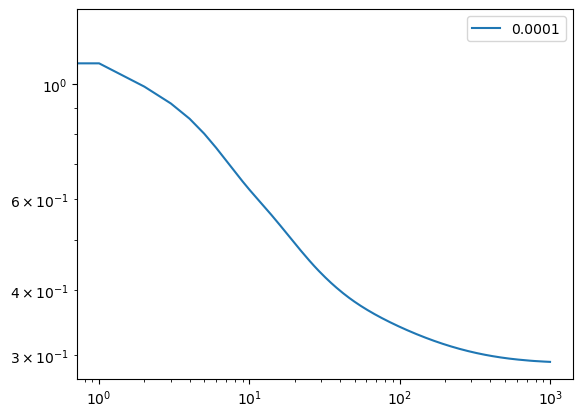

In [18]:
for lr, losses in loggers.items():
    plt.plot(losses, label=str(lr)) 

plt.yscale("log")
plt.legend()  
plt.xscale("log")  

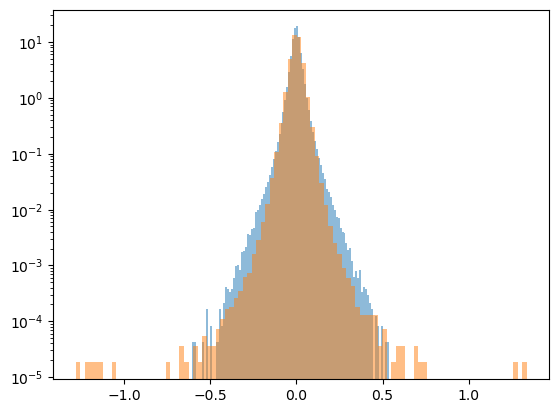

In [29]:
# plt.hist(weights.flatten().cpu().numpy(), bins=100, alpha=0.5, label="weights",
#             density=True)
plt.hist(A.flatten().detach().cpu().numpy(), bins=100, alpha=0.5, label="A",
            density=True)
plt.hist(B.flatten().detach().cpu().numpy(), bins=100, alpha=0.5, label="B",
          density=True)
plt.yscale("log")

In [20]:
A = A.detach()
B = B.detach()

0.00018167495727539062


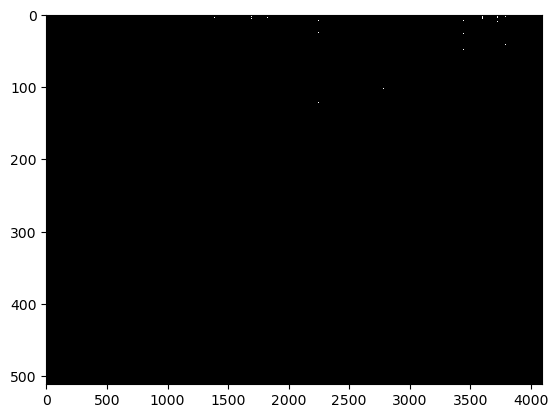

In [33]:
mask = torch.abs(B).cpu().numpy() >= 0.25
print(mask.sum()/mask.size)

plt.imshow(torch.abs(B).cpu().numpy() >= 0.25, cmap="gray",
              interpolation="nearest",
                aspect="auto")

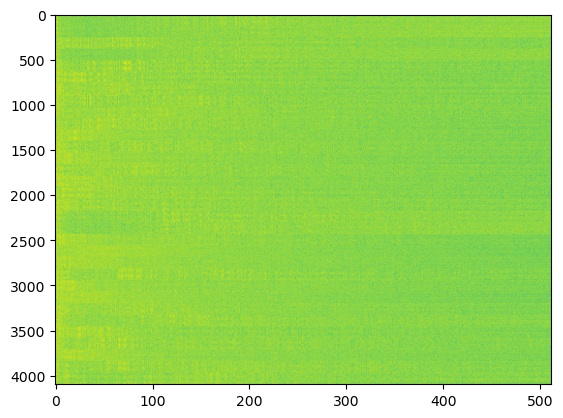

In [22]:
plt.imshow(np.log(np.abs(A_normalized.cpu().detach().numpy())), aspect="auto")

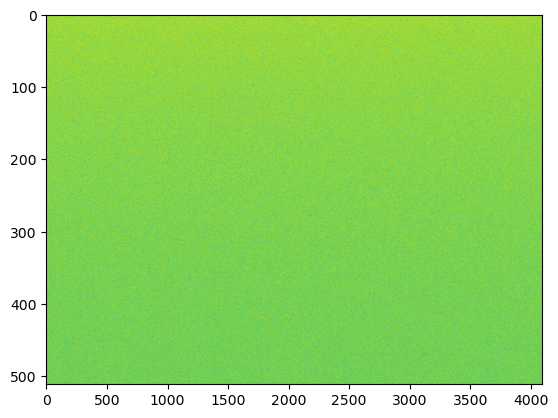

In [23]:
plt.imshow(np.log(np.abs(B_normalized.cpu().detach().numpy())), aspect="auto")

In [24]:
import sklearn.cluster as cluster

In [25]:
A.shape

torch.Size([4096, 512])

In [26]:
d = 4
n_bits_per_value = 2
n_centriods = 2**(d*n_bits_per_value)


A_reshaped = A.reshape(-1, d).detach().cpu().numpy()
B_reshaped = B.T.reshape(-1, d).detach().cpu().numpy()

total = np.concatenate([A_reshaped, B_reshaped], axis=0)
kmeans = cluster.KMeans(n_clusters=n_centriods, n_init=1, max_iter = 10).fit(total)

assignments = torch.from_numpy(kmeans.labels_).to(device).long()
centriods = torch.from_numpy(kmeans.cluster_centers_).to(device).float()

centriods

tensor([[ 0.0146, -0.0105,  0.0027, -0.0112],
        [-0.0155, -0.0322, -0.0168, -0.0072],
        [-0.0285,  0.0544, -0.0474,  0.0155],
        ...,
        [-0.0625,  0.0389, -0.0361, -0.0817],
        [ 0.1091, -0.0375,  0.0304,  0.1214],
        [ 0.0098,  0.0220,  0.0355, -0.0096]], device='cuda:5')

In [20]:
def codebook_adam(grads, m1,m2, lr = 1e-3, 
                  beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
    
    m1 = beta1*m1 + (1-beta1)*grads
    m2 = beta2*m2 + (1-beta2)*grads**2
    
    m1_hat = m1/(1-beta1)
    m2_hat = m2/(1-beta2)
    
    #return the update
    return lr*m1_hat/(torch.sqrt(m2_hat) + eps), m1, m2

In [ ]:
def get_grads(A,B, H, orig_weight, debug = False):
    with torch.no_grad():
        diff = orig_weight - A @ B
        loss = torch.einsum("ij,jk,ik->", diff, H, diff)
    
    A_grad = -2 * diff @ H @ B.t()
    # print((2* A.t() @ A @ B @ H).shape)
    B_grad = -2 * A.t() @ diff @ H
    
    total_grad = torch.cat([A_grad.reshape(-1, d), B_grad.T.reshape(-1, d)], axis=0)
    total_grad = torch.clip(total_grad, -0.01, 0.01)
    if debug:
        A_used = A.clone().requires_grad_()
        B_used = B.clone().requires_grad_()
        diff = orig_weight - A_used @ B_used
        loss = torch.einsum("ij,jk,ik->", diff, H, diff)
        loss.backward()
        #check the gradients are correct
        assert torch.allclose(A_used.grad, A_grad, atol = 1e-5), f"{A_used.grad} {A_grad}"
        assert torch.allclose(B_used.grad, B_grad, atol = 1e-5), f"{B_used.grad} {B_grad}"
    return loss.item(), total_grad

def accumulate_gradients(assignments, grads, n_centriods,stabelize = False):
    total_grads = torch.zeros(n_centriods, grads.shape[1]).to(device)
    counts = torch.zeros(n_centriods).to(device)
    for i in range(n_centriods):
        mask = (assignments == i).float()
        total_grads[i] = torch.sum(mask[:, None] * grads, dim=0)
        counts[i] = torch.sum(mask)
    
    if stabelize:
        counts += 1e-5
        total_grads = total_grads / counts[:, None]
    return total_grads, counts


def type1_estimate_L_smooth(grad_buffer, location_buffer):
    
    #grad buffer of shape (n_items, -1,d)
    #location buffer of shape (n_items, -1,d)
    L = 0
    for i in range(len(grad_buffer)):
        for j in range(i+1, len(grad_buffer)):
            grad_diff = grad_buffer[i] - grad_buffer[j]
            loc_diff = location_buffer[i] - location_buffer[j]
            L = max(L, torch.norm(grad_diff) / torch.norm(loc_diff))
    return L

def V_tune(current_values, grads, L, codebook, #shape of (n_centriods,d)
           current_assignments, blocksize: int = 2048):
    

    # change = grads / L
    # print("grad_max:", torch.max(torch.abs(grads)), "grad_min:", torch.min(torch.abs(grads)))
    # print("l1 norm of change", torch.mean(torch.abs(change)), "relative to the values", torch.mean(torch.abs(change)) / torch.mean(torch.abs(current_values)))
    # print("l2 norm of change", torch.sqrt(torch.mean(change**2)), "relative to the values", torch.sqrt(torch.mean(change**2)) / torch.sqrt(torch.mean(current_values**2)))  
    target_values = current_values - grads / L
    
    new_assignments = torch.zeros_like(current_assignments)
    
    for i in range(0, current_values.shape[0], blocksize):
        block = slice(i, i+blocksize)
        distances = torch.norm(target_values[block].unsqueeze(1) - codebook.unsqueeze(0), dim=2) #shape of (blocksize, n_centriods)
        new_assignments[block] = torch.argmin(distances, dim=1)
    
    return new_assignments, target_values

def convert_back_to_A_and_B(assignments, codebook,A_shape = A.shape, B_shape = B.shape):
    A_new = codebook[assignments[:A_reshaped.shape[0]]].reshape(A_shape)
    B_new = codebook[assignments[A_reshaped.shape[0]:]].reshape(B_shape[::-1]).T
    return A_new, B_new

def flatten_AB(A,B):
    return torch.cat([A.reshape(-1, d), B.T.reshape(-1, d)], axis=0)
    

In [63]:
n_buffer = 10
lr = 1e-3
n_iters = 1000
n_warmup = 0

centriods_m1 = torch.zeros_like(centriods).to(device)
centriods_m2 = torch.zeros_like(centriods).to(device)


grad_buffer = []
location_buffer = []

centriods_use = centriods.clone()
assignments_use = assignments.clone()
losses2 = []

A_ , B_ = convert_back_to_A_and_B(assignments_use, centriods_use)
Ls = []
#warm start for n_buffer steps without any v tuning
H_use = H/H.shape[0]
L_prev = 0
for i in range(n_iters):
    
    loss, total_grads = get_grads(A_,B_, H_use, weights)
    # print(loss)
    losses2.append(loss)
    if i% n_buffer == 0:
        print(loss)
        # raise ValueError("Not implemented")
    grad_buffer.append(total_grads.clone())
    location_buffer.append(flatten_AB(A_,B_).clone())

        
    grad_codebook, counts = accumulate_gradients(assignments, total_grads, n_centriods)
    update, centriods_m1, centriods_m2 = codebook_adam(grad_codebook, centriods_m1, centriods_m2, lr = lr)
    # print(update)
    centriods_use = centriods_use - update
        
    if i >= n_buffer:
        # raise ValueError("Not implemented")
        grad_buffer.pop(0)
        location_buffer.pop(0)
        if i > n_warmup:
            L = type1_estimate_L_smooth(grad_buffer, location_buffer)
            # print("L", L)
            # raise ValueError("Not implemented")
            assignments_new,targets = V_tune(flatten_AB(A_,B_), total_grads, 
                                    L,
                                    centriods_use, assignments_use)
            # print("n_changes", torch.sum(assignments_new != assignments_use).item()/assignments_use.shape[0])
            assignments_use = assignments_new
        # raise ValueError("Not implemented")
        
        # grad_buffer = []
        # location_buffer = []
        
    A_, B_ = convert_back_to_A_and_B(assignments_use, centriods_use)
    Ls.append(L.item())
    L_prev = L
    
    
    
        
        
        


540.7791137695312
449.9473876953125
641.8212890625
1191.572998046875
565.1863403320312
271.2427978515625
237.72149658203125
2751.73388671875
1610.1099853515625
1004.671630859375
1063.6893310546875
169206.125
1069.349853515625
814.7742919921875
633.0694580078125
525.6629638671875
10695.0947265625
5693.4765625
4738.7568359375
4655.060546875
4437.47119140625
2836.97607421875
16202.791015625
8331.50390625
7560.0400390625
5063.720703125
58526.0625
47158.4140625
38913.8515625
102754.8125
1104962.0
12573.099609375
12283.9365234375
4705.6337890625
55729.40234375
3279.70703125
2023.6673583984375
83377.8125
26073.11328125
13055.970703125
92935.953125
88935.3046875
20281.66796875
42467.41015625
25162.71875
2117.998779296875
3454.1767578125
8961.482421875
8225.189453125
10017.5634765625
51760.31640625
49026.08203125
3086.706787109375
1794.060546875
1841.05810546875
58749.2890625
6624.5732421875
32825.19921875
21972.064453125
7637.0341796875
20432.46875
19301.640625
7163.58154296875
51681.5546875
1

In [64]:
Ls

[2.971343517303467,
 2.971343517303467,
 2.971343517303467,
 2.971343517303467,
 2.971343517303467,
 2.971343517303467,
 2.971343517303467,
 2.971343517303467,
 2.971343517303467,
 2.971343517303467,
 2.332533121109009,
 6.411252498626709,
 12.661371231079102,
 12.661371231079102,
 12.661371231079102,
 12.661371231079102,
 12.661371231079102,
 12.661371231079102,
 12.661371231079102,
 12.661371231079102,
 12.661371231079102,
 6.182173252105713,
 13.375086784362793,
 13.375086784362793,
 13.375086784362793,
 13.375086784362793,
 13.375086784362793,
 13.375086784362793,
 13.375086784362793,
 13.375086784362793,
 13.375086784362793,
 3.455355167388916,
 7.190536975860596,
 9.14599609375,
 9.811121940612793,
 11.280035972595215,
 11.280035972595215,
 11.280035972595215,
 11.280035972595215,
 11.280035972595215,
 11.280035972595215,
 11.280035972595215,
 11.280035972595215,
 11.280035972595215,
 8.220577239990234,
 12.486648559570312,
 12.621641159057617,
 12.621641159057617,
 12.6216411590

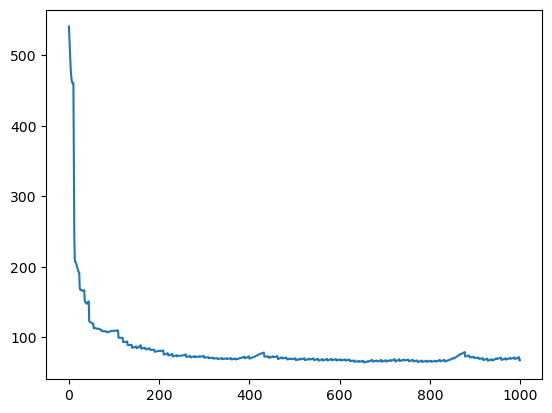

In [61]:
plt.plot(losses2)
# plt.plot(losses2)
# plt.plot(Ls)

In [110]:
A_targets = targets[:A_reshaped.shape[0]].reshape(A.shape)
B_targets = targets[A_reshaped.shape[0]:].reshape(B.shape[::-1]).T

get_grads(A_targets, B_targets, H/H.shape[0], weights)

(22376652.0,
 tensor([[ 5.9489e+04],
         [-1.2532e+03],
         [ 9.2215e+03],
         ...,
         [-3.0099e-02],
         [ 1.1108e+00],
         [-9.5200e-01]], device='cuda:6'))

In [111]:
diff = weights - A_targets @ B_targets
print(torch.mean(diff**2)/torch.mean(weights**2))

tensor(296.2285, device='cuda:6')


/tmp/ipykernel_499824/3547421352.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(diff.cpu().detach().numpy())), aspect="auto")


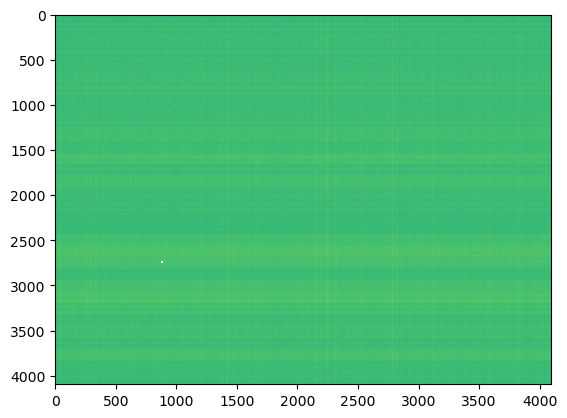

In [103]:
plt.imshow(np.log(np.abs(diff.cpu().detach().numpy())), aspect="auto")

In [100]:
A_targets @ B_targets

tensor([[-0.0186, -0.0136,  0.0045,  ...,  0.0248,  0.0008, -0.0398],
        [ 0.0153, -0.0010,  0.0206,  ..., -0.0202,  0.0292,  0.0023],
        [ 0.0195,  0.0020,  0.0023,  ...,  0.0186, -0.0087, -0.0040],
        ...,
        [ 0.0144, -0.0141,  0.0321,  ..., -0.0336,  0.0075,  0.0300],
        [ 0.0085, -0.0515, -0.0284,  ..., -0.0319,  0.0128,  0.0178],
        [ 0.0527,  0.0563,  0.0414,  ...,  0.0285, -0.0288, -0.0553]],
       device='cuda:6')

In [101]:
weights

tensor([[-0.0096, -0.0301,  0.0085,  ...,  0.0178, -0.0052, -0.0365],
        [-0.0029, -0.0101,  0.0100,  ...,  0.0147,  0.0040, -0.0104],
        [-0.0004,  0.0139, -0.0074,  ..., -0.0083, -0.0070,  0.0146],
        ...,
        [-0.0107, -0.0061,  0.0310,  ..., -0.0052, -0.0143,  0.0236],
        [-0.0104, -0.0213, -0.0129,  ..., -0.0199, -0.0143, -0.0103],
        [ 0.0184,  0.0119,  0.0195,  ...,  0.0343, -0.0327, -0.0355]],
       device='cuda:6')